# TUTORIAL: 
# Data assimilation using real experimental data

We can now put everything we have learned together. 

We can investigate two scenarios:

A) Assume that we have access to the post-processed data and assimilate it. This situation simplifies the problem as the experimental data is not biased (see tutorial TA_azimuthal_data to see how the raw data is biased).
-   Truth: post-processed data 
-   Observations: post-processed data + noise (possibly coloured noise)

B) Assume a realistic setting in which the post-processed data is not available on the fly to input to the data assimilation algorithm. Here, we need to address the issue of biased observations.
-   Truth: post-processed data
-   Observations: raw data

In this tutorial we will work with option B. For option A go to the tutorial ```10_DA_annular_ideal.ipynb```.

In [1]:
%matplotlib inline

import parent_folders # workaround path issue in jupyter notebook

import numpy as np
import os

rng = np.random.default_rng(0)


if os.path.isdir('/mscott/'):
    data_folder = '/mscott/an553/data/'  # set working directory to 
else:
    data_folder = "../data/"

## 1. Load data 
Create the reference truth and the observations.


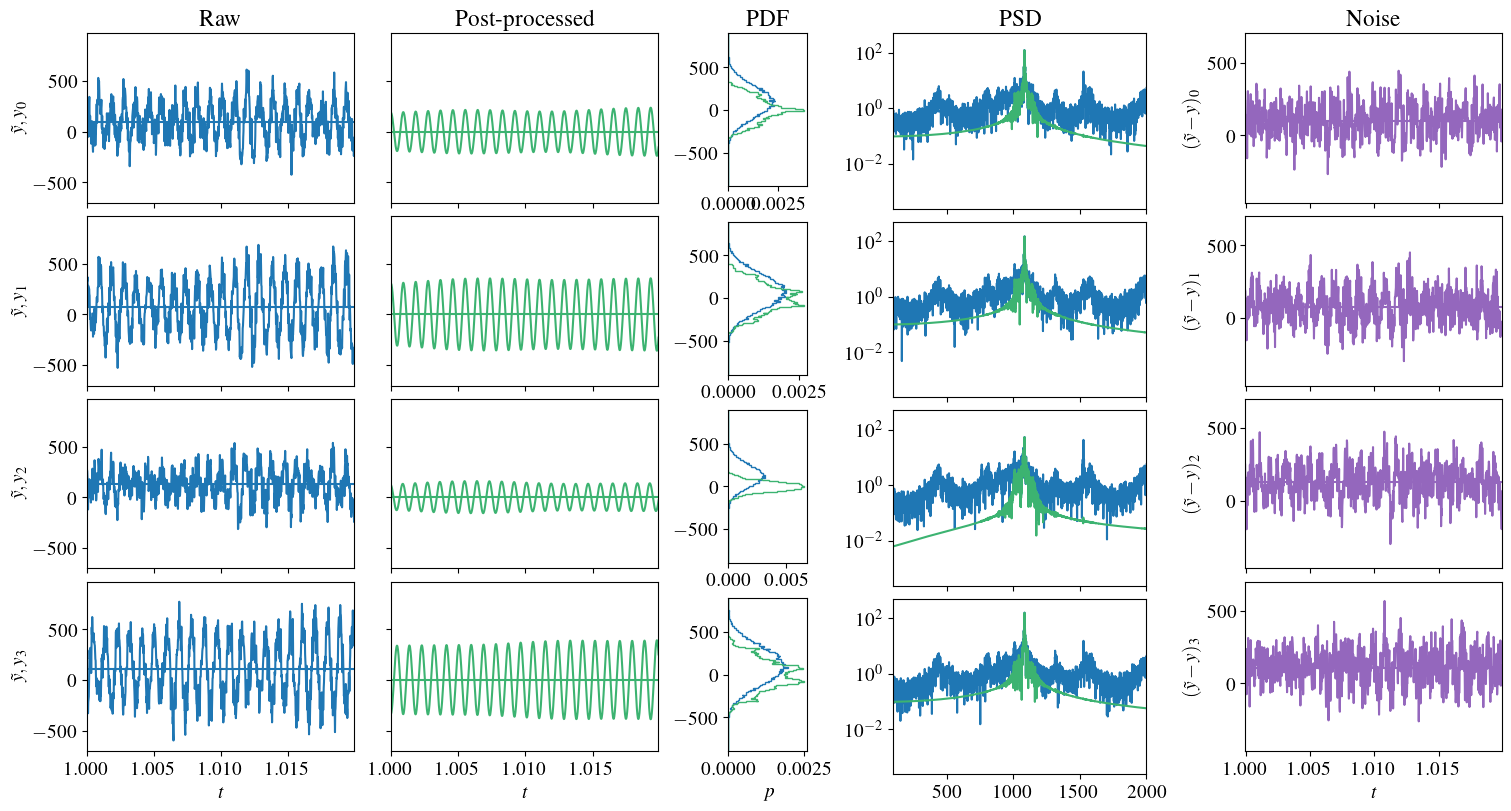

In [2]:
from essentials.create import create_truth
from essentials.physical_models import Annular
from essentials.plotResults import plot_truth

ER = 0.5125   # .4875 .5125 .5375 .5625
filename = data_folder + 'annular/ER_{}'.format(ER)

# Select the observations time-window
t_start = 1.0
t_stop = t_start + Annular.t_CR * 2
Nt_obs = 15

truth = create_truth(filename, t_start, t_stop, Nt_obs, post_processed=False)
plot_truth(**truth)


## 2. Define the forecast model
This is the physical model which we will use to model the true data.
Here, we select the filter parameters and create ensemble


In [3]:
from essentials.create import create_ensemble


nu = Annular.nu_from_ER(ER)
c2beta = Annular.c2beta_from_ER(ER)

filter_params = {'m': 20, 
                 'inflation': 1.002,
                 'std_psi': 0.3,
                 'std_a': dict(nu=(nu-10., nu+10.),
                               c2beta=(c2beta-10, c2beta+10),
                               kappa=(1.E-4, 1.3E-4),
                               epsilon=(0.0001, 0.03),
                               omega=(1090 * 2 * np.pi, 1100 * 2 * np.pi),
                               theta_b=(0.5, 0.7),
                               theta_e=(0.5, 0.8)
                               )}

ensemble = create_ensemble(model=Annular, **filter_params)

ensemble_no_bias = ensemble.copy()
ensemble_ESN = ensemble.copy()


## 4. Train an ESN to model the model bias
The procedure is the following

&emsp; i. Initialise ESN Bias class object
&emsp; ii. Create synthetic bias to use as training data 
&emsp; iii. Train the ESN
&emsp; iv. Create washout data

Rerun multi-parameter training data: Increase the length of the training data
sparsity =  0.9620253164556962
rho =  1.1267010553793493

 ----------------- HYPERPARAMETER SEARCH ------------------
 4x4 grid and 4 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 5.000e-01	 1.000e-05	 1.000e-10	 -5.2048
2	 5.000e-01	 1.000e-03	 1.000e-10	 -5.0590
3	 5.000e-01	 1.000e-01	 1.000e-10	 25.6036
4	 5.000e-01	 1.000e+01	 1.000e-16	 -4.1704
5	 7.000e-01	 1.000e-05	 1.000e-10	 -5.1916
6	 7.000e-01	 1.000e-03	 1.000e-10	 -5.0026
7	 7.000e-01	 1.000e-01	 1.000e-16	 6.2072
8	 7.000e-01	 1.000e+01	 1.000e-16	 -4.0161
9	 9.000e-01	 1.000e-05	 1.000e-10	 -5.2529
10	 9.000e-01	 1.000e-03	 1.000e-10	 -4.8288
11	 9.000e-01	 1.000e-01	 1.000e-10	 -5.0167
12	 9.000e-01	 1.000e+01	 1.000e-16	 -4.4812
13	 1.100e+00	 1.000e-05	 1.000e-10	 22.8474
14	 1.100e+00	 1.000e-03	 1.000e-10	 27.1989
15	 1.100e+00	 1.000e-01	 1.000e-10	 22.6537
16	 1.100e+00	 1.000e+01	 1.000e-16	 -4.3840
17	 5.000e-

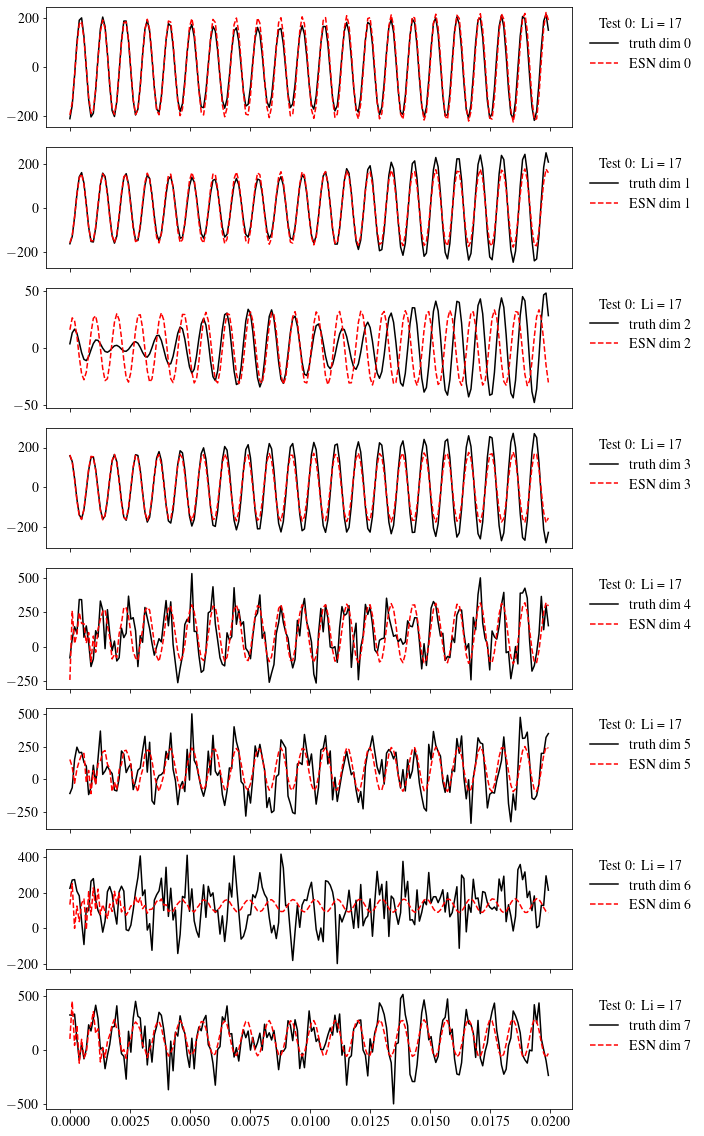

In [4]:
from essentials.create import create_bias_training_dataset, create_washout
from essentials.bias_models import ESN

train_params = dict(bias_model=ESN, 
                    upsample=5,
                    N_units=80,
                    N_wash=10,
                    t_train=ensemble.t_CR * 20,
                    t_val=ensemble.t_CR * 2,
                    # Bayesian update to the ESN state
                    bayesian_update=True,
                    biased_observations=True,
                    update_reservoir=False,
                    m=10,
                    # Training data generation options
                    augment_data=True,
                    L=10,
                    # Hyperparameter search ranges
                    rho_range=(0.5, 1.1),
                    sigma_in_range=(np.log10(1e-5), np.log10(1e1)),
                    tikh_range=[1e-16, 1e-10]
                    )

# 4.1. Initialise the ESN
ensemble_ESN.init_bias(**train_params)

# 4.2. Create training data
train_data = create_bias_training_dataset(truth['y_raw'], truth['y_true'], ensemble_ESN, **train_params)


# 4.3. Train the ESN
# The training convergence, hyperparameter optimization and testing results are saved in a pdf file in figs_ESN folder.
ensemble_ESN.bias.train_bias_model(**train_data) 

# 4.4. Create washout data
ensemble_ESN.t_init = truth['t_obs'][0]
ensemble_ESN.bias.t_init = ensemble_ESN.t_init - 2 * Nt_obs * truth['dt']
wash_t, wash_obs = create_washout(bias_case=ensemble_ESN.bias, **truth)



## 5. Apply data assimilation
We now have all the ingredients to start our data assimilation algorithm.

In [5]:
from essentials.DA import dataAssimilation



std_obs = 0.1

kwargs = dict(y_obs=truth['y_obs'], t_obs=truth['t_obs'], std_obs=std_obs, wash_obs=wash_obs, wash_t=wash_t)


ensemble_ESN.filter = 'rBA_EnKF'
ensemble_ESN.regularization_factor = 2.
ensemble_no_bias.filter ='EnSRKF'


out = []
for ens in [ensemble_no_bias, ensemble_ESN]:
# for ens in [ensemble_ESN]:
    ens = ens.copy()
    ens.inflation = 1.00
    filter_ens = dataAssimilation(ens, **kwargs.copy())
    
    #Forecast the ensemble further without assimilation
    Nt_extra = int(filter_ens.t_CR / filter_ens.dt) + 1
    
    psi, t = filter_ens.time_integrate(Nt_extra)
    filter_ens.update_history(psi, t)
    
    y = filter_ens.get_observable_hist(Nt_extra)
    b, t_b = filter_ens.bias.time_integrate(t=t, y=y)
    filter_ens.bias.update_history(b, t_b)
    
    out.append(filter_ens)
    # out[-1] = filter_ens



 ------------------ Annular Model Parameters ------------------ 
	 ER = 0.5
	 Nq = 4
	 c2beta = 24.1088
	 dt = 1.95313e-05
	 epsilon = 0.01505
	 kappa = 0.000115
	 n = 1.0
	 nu = -6.58288
	 omega = 6880.09
	 theta_b = 0.6
	 theta_e = 0.65

 ----------------  Bias model parameters ----------------  
 Bias model: NoBias

 -------------------- ASSIMILATION PARAMETERS -------------------- 
 	 Filter = EnSRKF  
	 bias = NoBias 
 	 m = 20 
 	 Time steps between analysis = None 
 	 Inferred params = ['nu', 'c2beta', 'kappa', 'epsilon', 'omega', 'theta_b', 'theta_e'] 
 	 Inflation = 1.0 
 	 Ensemble std(psi0) = 0.3
 	 Ensemble std(alpha0) = {'nu': (-16.582875, 3.4171249999999986), 'c2beta': (14.10875, 34.10875), 'kappa': (0.0001, 0.00013), 'epsilon': (0.0001, 0.03), 'omega': (6848.671984825749, 6911.503837897545), 'theta_b': (0.5, 0.7), 'theta_e': (0.5, 0.8)}
 	 Number of analysis steps = 69, t0=0.99998046875, t1=1.01990234375
 --------------------------------------------
Elapsed time to firs

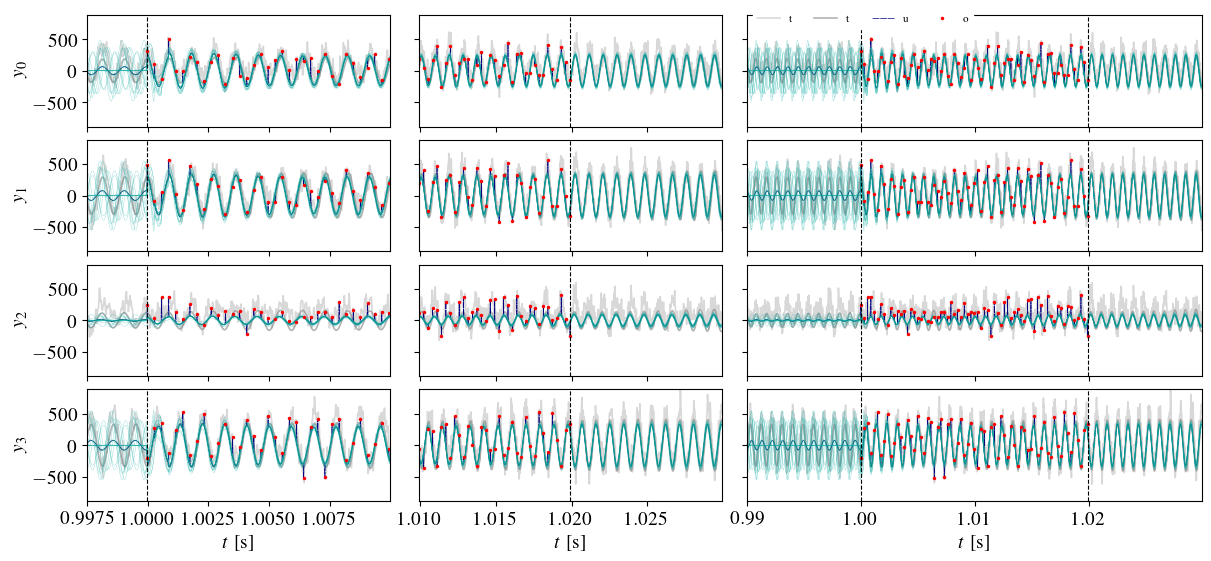

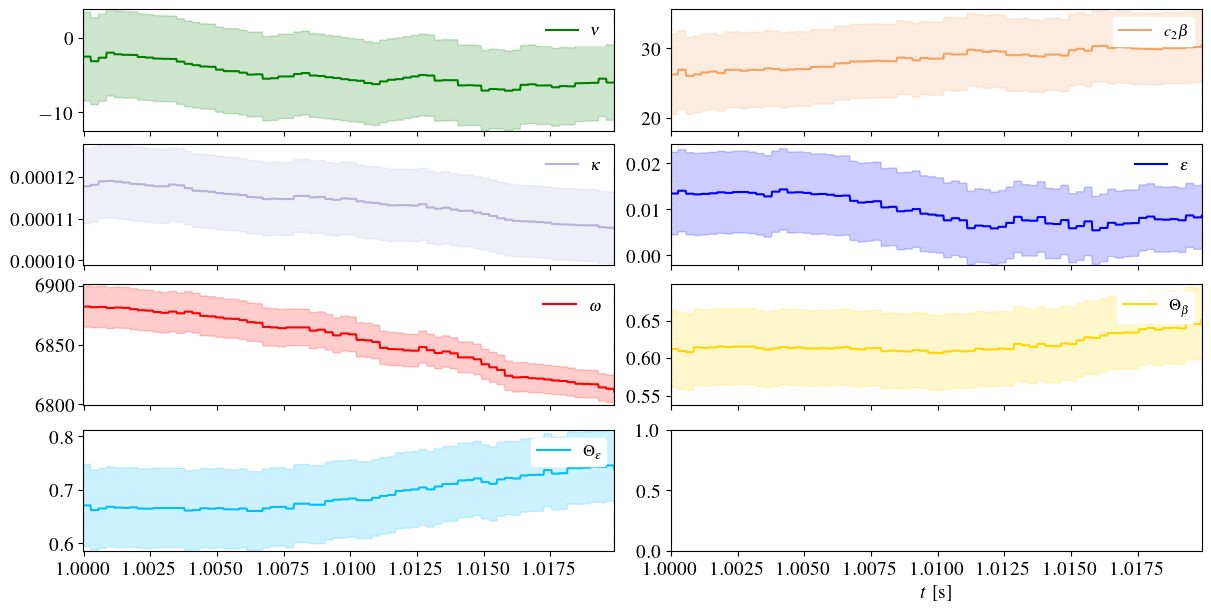

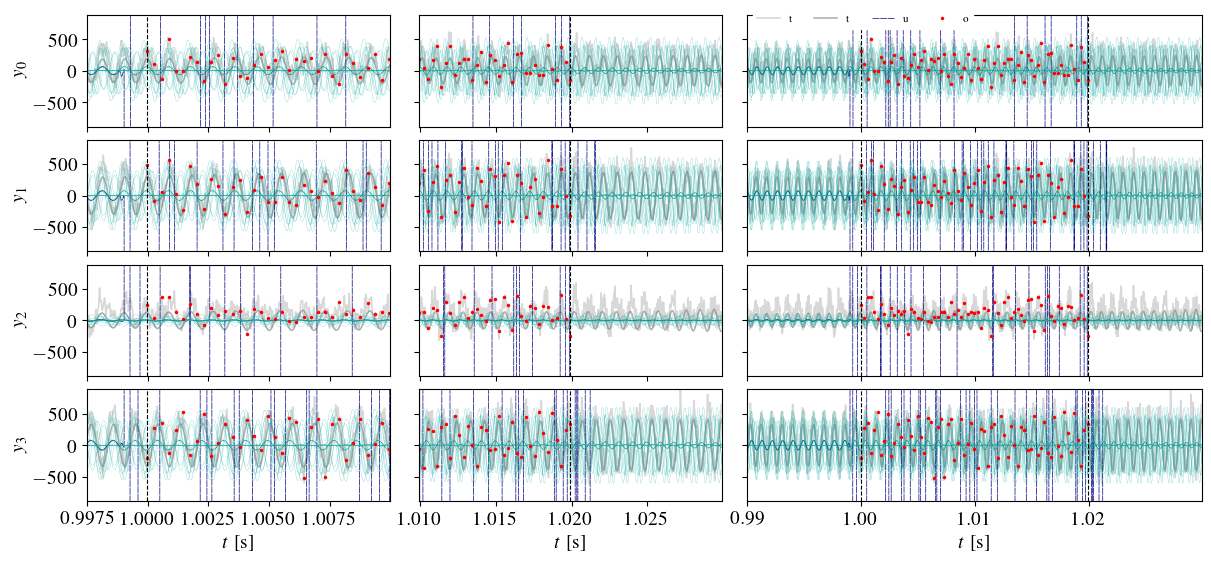

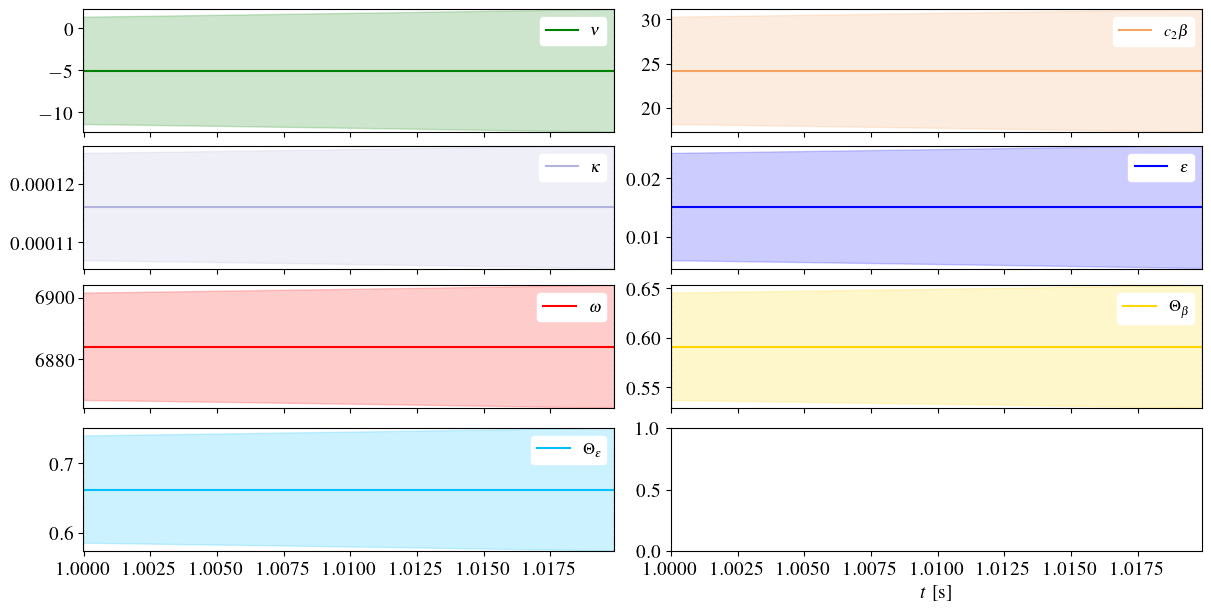

In [6]:
from essentials.plotResults import plot_timeseries, plot_parameters

%matplotlib inline
# %matplotlib qt

for filter_ens in out:
    plot_timeseries(filter_ens, truth)
    plot_parameters(filter_ens, truth)

/Users/andreanovoa/anaconda3/envs/C-EnKF/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


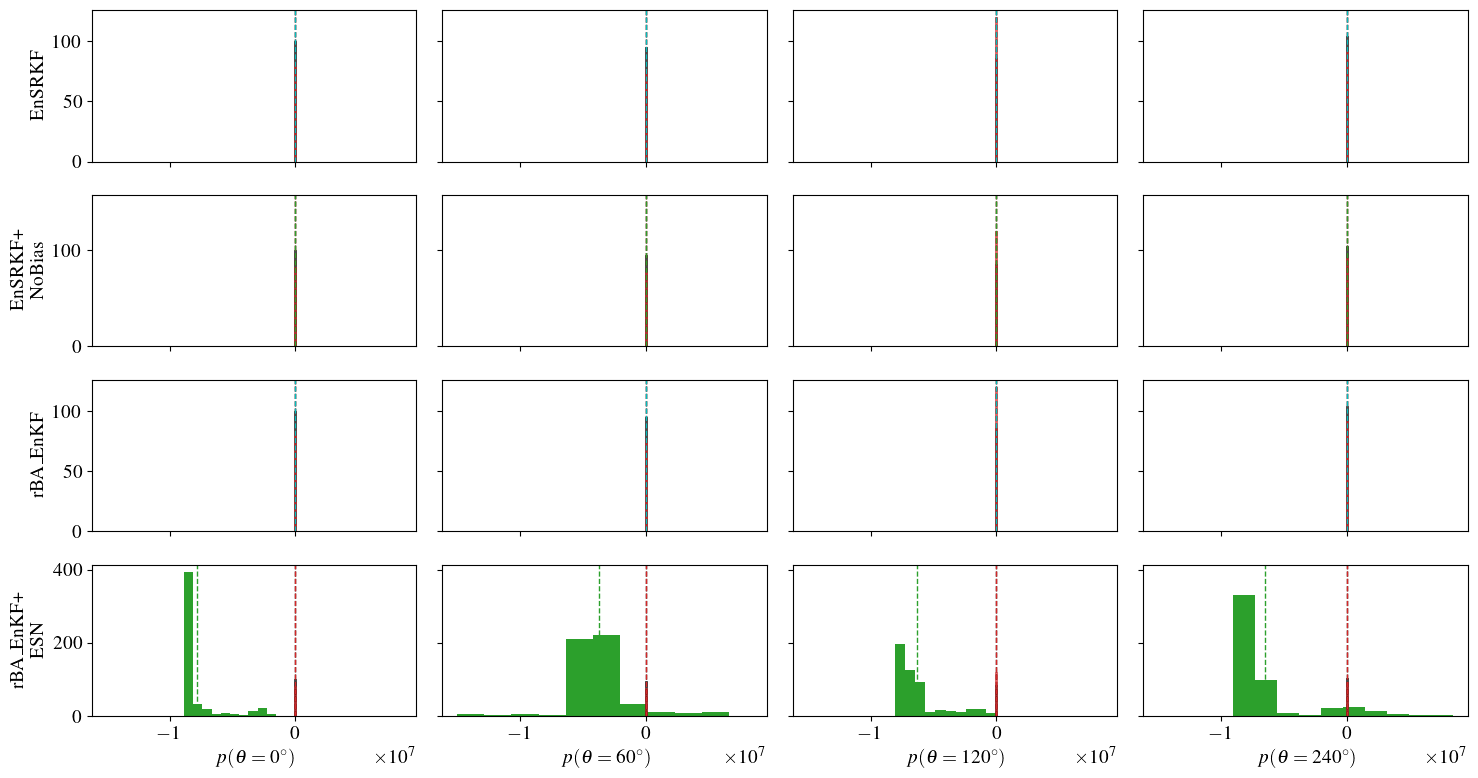

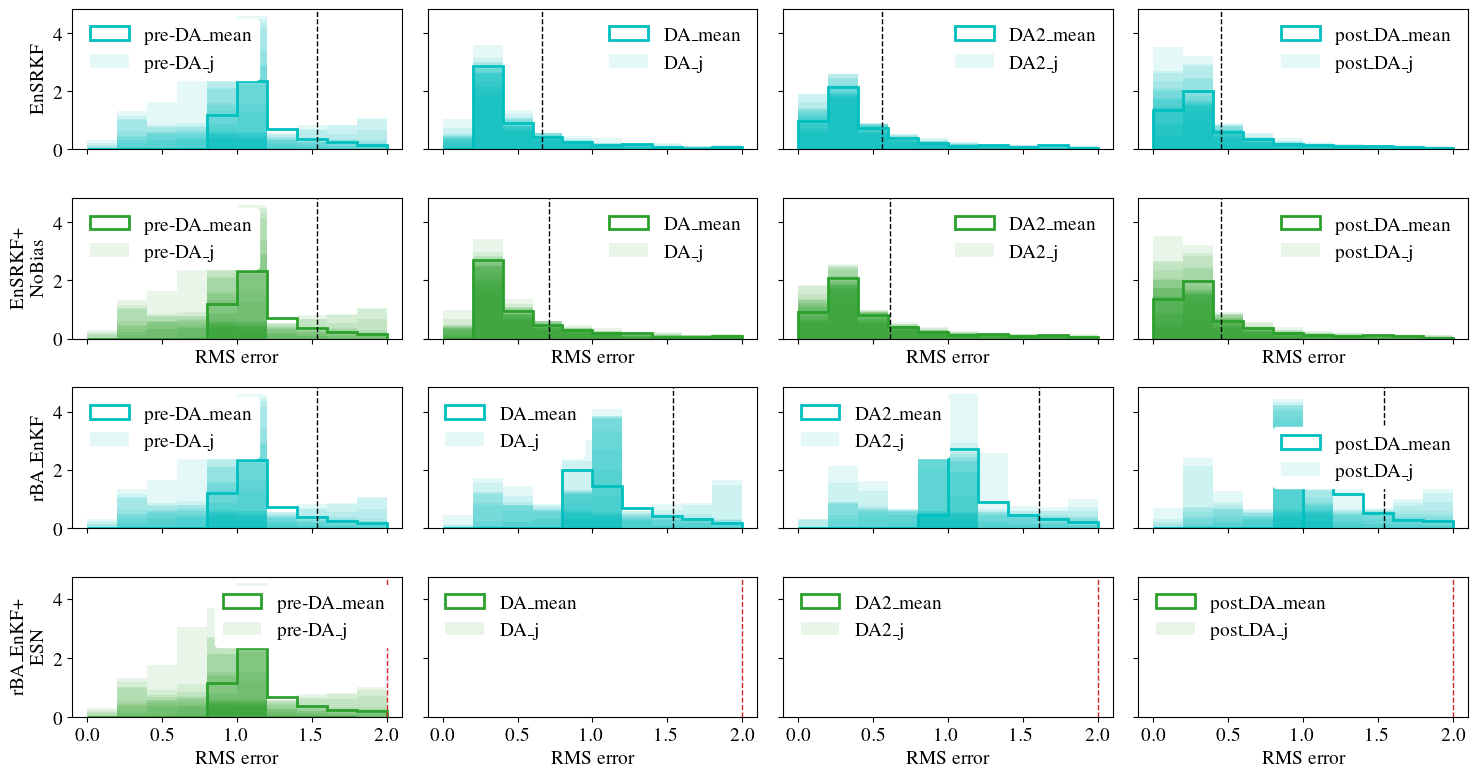

In [7]:
from essentials.plotResults import plot_states_PDF, plot_RMS_pdf
plot_states_PDF(out, truth, nbins=10)
plot_RMS_pdf(out, truth, nbins=10)
